In [182]:
# pip install ipypb

In [2]:
import pandas as pd
import numpy as np
# 진행상황을 확인
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
final = pd.read_csv('C:/Users/zxoro/OneDrive/바탕 화면/더스포츠커뮤니케이션 자료/data/final.csv')

# RFM 분석에 필요한 데이터프레임 정리 
final = final.sort_values(by='game_date')
final = final.reset_index()
final['game_date'] = pd.to_datetime(final['game_date'])
final.drop(['ticket_no', 'product_denomination_name','audience', 'index','game_time','match_info','product_grade_name','seat_Attribute_4','rank','sale','reserve_diff','MB_AGE','job','favorite_idx'], axis = 1, inplace = True)

In [3]:
df_rfm = final.copy()
df_rfm

,membership_no,game_date,new_price
0,102806,2022-02-19,19000
1,138215,2022-02-19,13000
2,138215,2022-02-19,19500
3,125933,2022-02-19,12000
4,143862,2022-02-19,57000
...,...,...,...
25147,136617,2022-10-16,10500
25148,136617,2022-10-16,63000
25149,136617,2022-10-16,42000
25150,149857,2022-10-16,42000


In [4]:
# RECENCY
# Recency에서 제일 최근에서 값을 뺌
# 점수를 부여할 경우 5,4,3,2,1으로 부여함
recency = pd.DataFrame(df_rfm.groupby('membership_no')['game_date'].max().reset_index())
recency['game_date'] = pd.to_datetime(recency['game_date'])
recency['MaxDate'] = recency['game_date'].max()
recency['recency'] = (recency['MaxDate'] - recency['game_date']).dt.days + 1
recency = recency[['membership_no','recency']]
recency.head()

,membership_no,recency
0,137,141
1,153,1
2,180,1
3,208,1
4,291,1


In [5]:
# Frequecy
frequency = pd.DataFrame(df_rfm.groupby('membership_no')['game_date'].count().reset_index())
frequency.columns = ['fCustomerID','frequency']
frequency.head()

,fCustomerID,frequency
0,137,1
1,153,11
2,180,2
3,208,22
4,291,29


In [6]:
# MONETARY
monetary = pd.DataFrame(df_rfm.groupby('membership_no')['new_price'].sum().reset_index())
monetary.columns = ['mCustomerID','monetary']
monetary.head()

,mCustomerID,monetary
0,137,100000
1,153,164000
2,180,61000
3,208,281000
4,291,609000


In [7]:
# combining the three into one table
rfm = pd.concat([recency,frequency,monetary], axis=1)
rfm.drop(['fCustomerID','mCustomerID'], axis=1, inplace=True)
rfm

,membership_no,recency,frequency,monetary
0,137,141,1,100000
1,153,1,11,164000
2,180,1,2,61000
3,208,1,22,281000
4,291,1,29,609000
...,...,...,...,...
7422,151972,1,1,40000
7423,151978,1,1,14000
7424,151980,1,1,14000
7425,151981,1,1,30000


In [8]:
# extracting SPEED OF VISIT

customer_list = list(df_rfm.membership_no.unique())
c = []
v = []
for ids in customer_list:
    sov = df_rfm[df_rfm['membership_no']==ids].groupby('game_date')['new_price'].count().reset_index()
    if sov.shape[0]>3:
        sov['game_date1'] = sov['game_date'].shift(1)
        sov['Difference'] = (sov['game_date']-sov['game_date1']).dt.days
        mean_days = round(sov.Difference.mean(),0)
        c.append(ids)
        v.append(mean_days)
    else:
        c.append(ids)
        v.append(0)
speed_of_visit = pd.DataFrame()
speed_of_visit['sCustomerID'] = c
speed_of_visit['sov'] = v
speed_of_visit = speed_of_visit.sort_values('sCustomerID').reset_index(drop=True)
speed_of_visit.head()

,sCustomerID,sov
0,137,0.0
1,153,24.0
2,180,0.0
3,208,14.0
4,291,16.0


In [9]:
# checking the summary
rfm.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

,membership_no,recency,frequency,monetary
count,7427.000000,7427.000000,7427.000000,7.427000e+03
mean,134908.826444,78.712805,3.386563,9.560307e+04
std,21358.751306,80.830038,4.413840,1.258049e+05
min,137.000000,1.000000,1.000000,6.000000e+03
25%,125997.000000,6.000000,1.000000,2.600000e+04
50%,143545.000000,51.000000,2.000000,5.200000e+04
75%,148347.000000,153.000000,4.000000,1.050000e+05
90%,150560.600000,218.000000,8.000000,2.240000e+05
95%,151255.700000,233.000000,12.700000,3.340000e+05
99%,151847.740000,240.000000,22.000000,6.502200e+05


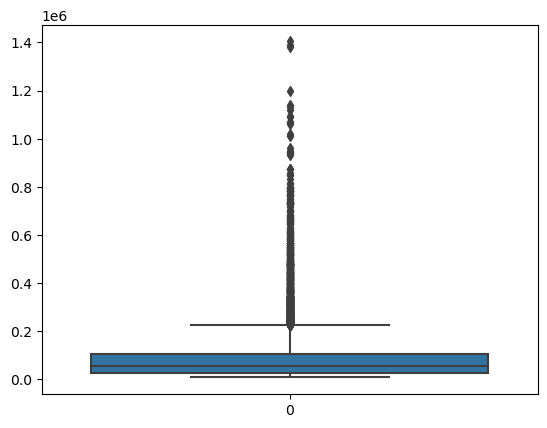

In [10]:
##이상치 제거하기 
import seaborn as sns
sns.boxplot(rfm.monetary)

# Monetary 이상치 제거하기 
1.3*1e6
rfm[rfm['monetary'] > 1000000].index
# 이상치 제거한 데이터 프레임 
# drop = True 하지 않으면 index컬럼이 하나 더 생김
rfm = rfm.drop(rfm[rfm['monetary'] > 1000000].index, axis = 0).reset_index(drop=True)

In [192]:
# bins나누는 방법
# rfm['frequency'].describe()
# rfm['recency'].describe(percentiles=[.25,.5,.75,.9])

In [11]:
# assigning the numbers to RFM values. The better the RFM value higher the number
# note that this process is reverse for R score as lower the value the better it is
# 통계량 파악해서 알맞은 구간 설정해주기 
rfm['recency_score'] = pd.cut(rfm['recency'], bins=[0,6,51,153,218,245], labels=[5,4,3,2,1])
rfm['recency_score'] = rfm['recency_score'].astype('int')
rfm['frequency_score'] = pd.cut(rfm['frequency'], bins=[0,1,2,4,8,40], labels=[1,2,3,4,5])
rfm['frequency_score'] = rfm['frequency_score'].astype('int')
rfm['monetary_score'] = pd.cut(rfm['monetary'], bins=[0,26000,52000,104000,222000,970000], labels=[1,2,3,4,5])
rfm['monetary_score'] = rfm['monetary_score'].astype('int')

In [12]:
# summing the R,F,M score to make a one single column that has value range from 3-15
def score_rfm(x) : return (x['recency_score']) + (x['frequency_score']) + (x['monetary_score'])
rfm['score'] = rfm.apply(score_rfm,axis=1 )
rfm

,membership_no,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score
0,137,141,1,100000,3,1,3,7
1,153,1,11,164000,5,5,4,14
2,180,1,2,61000,5,2,3,10
3,208,1,22,281000,5,5,5,15
4,291,1,29,609000,5,5,5,15
...,...,...,...,...,...,...,...,...
7408,151972,1,1,40000,5,1,2,8
7409,151978,1,1,14000,5,1,1,7
7410,151980,1,1,14000,5,1,1,7
7411,151981,1,1,30000,5,1,2,8


In [13]:
# assigning the customers into one of the category Bad, Bronze, Silver, Gold and Platinum based upon the score they get
# we make cuts using percentiles. It can be done in many other ways

rfm['customer_type'] = pd.cut(rfm['score'], bins=[0,6,8,11,13,15], labels=['Bad','Bronze','Silver','Gold','Platinum'])
rfm

,membership_no,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score,customer_type
0,137,141,1,100000,3,1,3,7,Bronze
1,153,1,11,164000,5,5,4,14,Platinum
2,180,1,2,61000,5,2,3,10,Silver
3,208,1,22,281000,5,5,5,15,Platinum
4,291,1,29,609000,5,5,5,15,Platinum
...,...,...,...,...,...,...,...,...,...
7408,151972,1,1,40000,5,1,2,8,Bronze
7409,151978,1,1,14000,5,1,1,7,Bronze
7410,151980,1,1,14000,5,1,1,7,Bronze
7411,151981,1,1,30000,5,1,2,8,Bronze


In [14]:
# 고객 세분화 진행을 위해 파일 저장하기, 고객 분석
# rfm.to_csv('./rfm.csv', index = False)

In [197]:
# 태블로 분석하기 위해서 저장해둠
# rfm.to_csv('rfm_analysis.csv', index = False)

In [21]:
round(rfm.customer_type.value_counts(normalize=True)*100,0)

Bad         35.0
Bronze      24.0
Silver      21.0
Gold        10.0
Platinum    10.0
Name: customer_type, dtype: float64

In [22]:
# looking the RFM value for each of the category
rfm.groupby('customer_type')['recency','frequency','monetary'].mean().round(0)

C:\Users\zxoro\AppData\Local\Temp\ipykernel_11556\3445396440.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rfm.groupby('customer_type')['recency','frequency','monetary'].mean().round(0)


,recency,frequency,monetary
customer_type,,,
Bad,154.0,1.0,28267.0
Bronze,64.0,2.0,50201.0
Silver,35.0,3.0,91686.0
Gold,16.0,6.0,175125.0
Platinum,4.0,14.0,359322.0


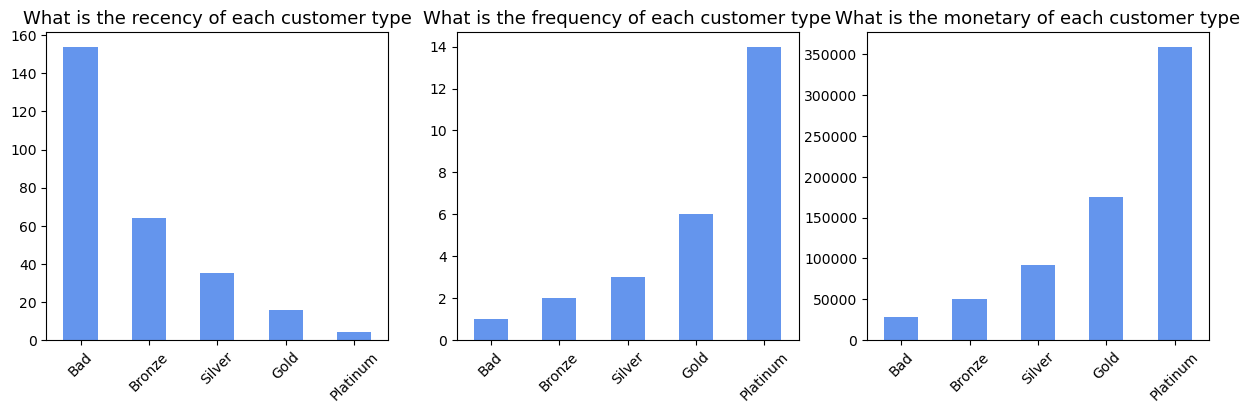

In [26]:
import matplotlib.pyplot as plt
column = ['recency','frequency','monetary']
plt.figure(figsize=(15,4))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    rfm.groupby('customer_type')[j].mean().round(0).plot(kind='bar', color='cornflowerblue')
    plt.title('What is the {} of each customer type'.format(j), size=13)
    plt.xlabel('')
    plt.xticks(rotation=45)

plt.show()

In [29]:
# copying the data into new variable
df_kmeans = rfm.copy()
# taking only relevant columns
df_kmeans = df_kmeans.iloc[:,:4]
df_kmeans.head()

,membership_no,recency,frequency,monetary
0,137,141,1,100000
1,153,1,11,164000
2,180,1,2,61000
3,208,1,22,281000
4,291,1,29,609000


In [30]:
df_kmeans_c = df_kmeans.copy()

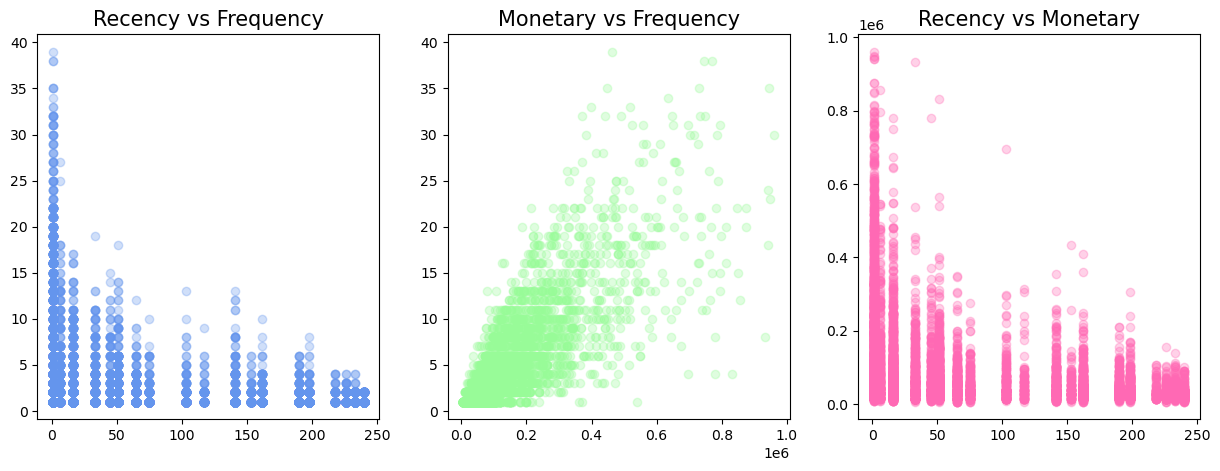

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df_kmeans.recency, df_kmeans.frequency, color='cornflowerblue', alpha=0.3)
plt.title('Recency vs Frequency', size=15)
plt.subplot(1,3,2)
plt.scatter(df_kmeans.monetary, df_kmeans.frequency, color='palegreen', alpha=0.3)
plt.title('Monetary vs Frequency', size=15)
plt.subplot(1,3,3)
plt.scatter(df_kmeans.recency, df_kmeans.monetary, color='hotpink', alpha=0.3)
plt.title('Recency vs Monetary', size=15)
plt.show()

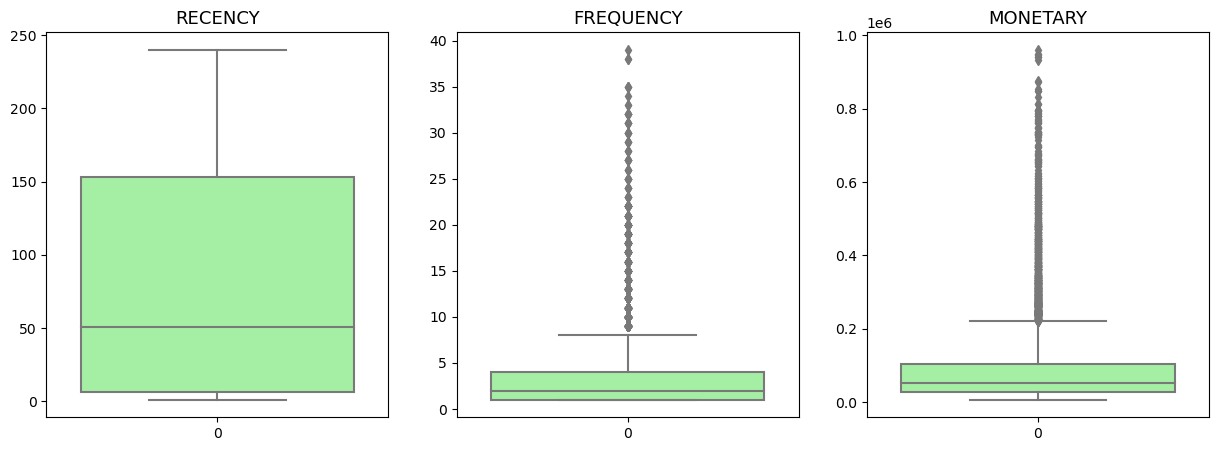

In [36]:
# checking the distribution of the variables
column = ['recency','frequency','monetary']
plt.figure(figsize=(15,5))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    sns.boxplot(df_kmeans[j], color='palegreen')
    plt.xlabel('')
    plt.title('{}'.format(j.upper()), size=13)
plt.show()

In [206]:
# Removing outliers for Monetary
Q1 = df_kmeans.monetary.quantile(0.05)
Q3 = df_kmeans.monetary.quantile(0.95)
IQR = Q3 - Q1
df_kmeans = df_kmeans[(df_kmeans.monetary >= Q1 - 1.5*IQR) & (df_kmeans.monetary <= Q3 + 1.5*IQR)]

# # Removing outliers for Recency
# Q1 = df_kmeans.recency.quantile(0.05)
# Q3 = df_kmeans.recency.quantile(0.95)
# IQR = Q3 - Q1
# df_kmeans = df_kmeans[(df_kmeans.recency >= Q1 - 1.5*IQR) & (df_kmeans.recency <= Q3 + 1.5*IQR)]

# Removing outliers for Frequency
Q1 = df_kmeans.frequency.quantile(0.05)
Q3 = df_kmeans.frequency.quantile(0.95)
IQR = Q3 - Q1
df_kmeans = df_kmeans[(df_kmeans.frequency >= Q1 - 1.5*IQR) & (df_kmeans.frequency <= Q3 + 1.5*IQR)]

In [207]:
# resetting the index
df_kmeans = df_kmeans.reset_index(drop=True)
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7372 entries, 0 to 7371
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   membership_no  7372 non-null   int64
 1   recency        7372 non-null   int64
 2   frequency      7372 non-null   int64
 3   monetary       7372 non-null   int64
dtypes: int64(4)
memory usage: 230.5 KB


In [208]:
# removing customer id as it will not used in making cluster
df_kmeans = df_kmeans.iloc[:,1:]

# scaling the variables and store it in different df
standard_scaler = StandardScaler()
df_kmeans_norm = standard_scaler.fit_transform(df_kmeans)

# converting it into dataframe
df_kmeans_norm = pd.DataFrame(df_kmeans_norm)
df_kmeans_norm.columns = ['recency','frequency','monetary']
df_kmeans_norm.head()

,recency,frequency,monetary
0,0.763344,-0.572909,0.091209
1,-0.968178,2.018662,0.687389
2,-0.968178,-0.313752,-0.272089
3,-0.968178,4.869389,1.777282
4,-0.572401,0.463720,-0.216197


In [209]:
# To perform KMeans clustering 
from sklearn.cluster import KMeans
# Kmeans with K=5

model_clus5 = KMeans(n_clusters = 5)
model_clus5.fit(df_kmeans_norm)

KMeans(n_clusters=5)

In [210]:
# checking the labels
model_clus5.labels_

array([3, 0, 1, ..., 1, 1, 1])

In [211]:
df_kmeans['clusters'] = model_clus5.labels_
df_kmeans

,recency,frequency,monetary,clusters
0,141,1,100000,3
1,1,11,164000,0
2,1,2,61000,1
3,1,22,281000,2
4,33,5,67000,4
...,...,...,...,...
7367,1,1,40000,1
7368,1,1,14000,1
7369,1,1,14000,1
7370,1,1,30000,1


In [212]:
df_kmeans.groupby('clusters').mean().round(0)

,recency,frequency,monetary
clusters,,,
0,12.0,10.0,278235.0
1,36.0,2.0,46565.0
2,3.0,18.0,497995.0
3,190.0,2.0,41421.0
4,24.0,5.0,145751.0


```
Finding the Optimal Number of Clusters
Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.
```

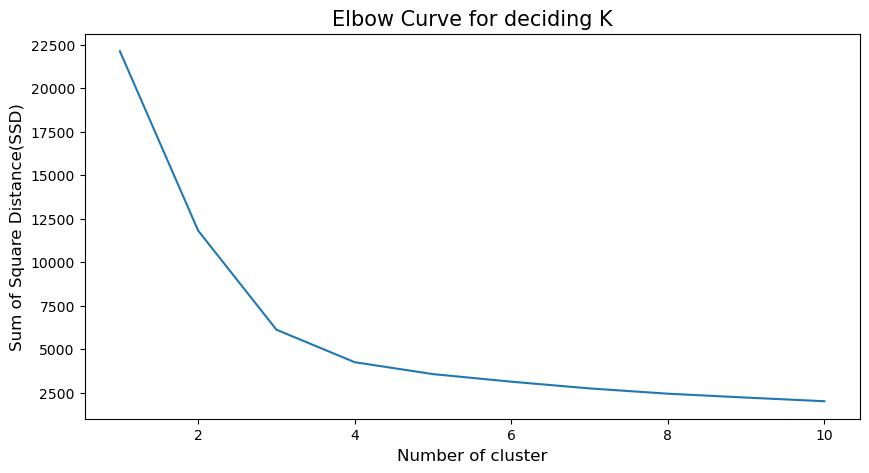

In [213]:
# Elbow-curve/SSD

ssd = []
for num_clusters in list(range(1,11)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_kmeans_norm)
    ssd.append(model_clus.inertia_)
    
# plot the SSDs for each n_clusters
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,11,1), ssd)
plt.xlabel('Number of cluster', size=12)
plt.ylabel('Sum of Square Distance(SSD)', size=12)
plt.title('Elbow Curve for deciding K', size=15)
plt.show()

In [214]:
# Silhouette analysis
from sklearn.metrics import silhouette_score

for num_clusters in list(range(2,11)):
    # intialise kmeans
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_kmeans_norm)
    
    cluster_labels = model_clus.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_kmeans_norm, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5841101263196232
For n_clusters=3, the silhouette score is 0.5495504983423403
For n_clusters=4, the silhouette score is 0.5468960399700511
For n_clusters=5, the silhouette score is 0.5005120671881578
For n_clusters=6, the silhouette score is 0.44474091735563165
For n_clusters=7, the silhouette score is 0.4439801804360364
For n_clusters=8, the silhouette score is 0.42240976048061213
For n_clusters=9, the silhouette score is 0.37590571452119004
For n_clusters=10, the silhouette score is 0.3808951466463931


In [215]:
# Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3)
model_clus3.fit(df_kmeans_norm)

KMeans(n_clusters=3)

In [216]:
df_kmeans['clusters'] = model_clus3.labels_
df_kmeans.head()

,recency,frequency,monetary,clusters
0,141,1,100000,1
1,1,11,164000,2
2,1,2,61000,0
3,1,22,281000,2
4,33,5,67000,0


In [217]:
df_kmeans.groupby('clusters').mean().round(0)

,recency,frequency,monetary
clusters,,,
0,33.0,2.0,69295.0
1,190.0,2.0,42791.0
2,10.0,12.0,330637.0


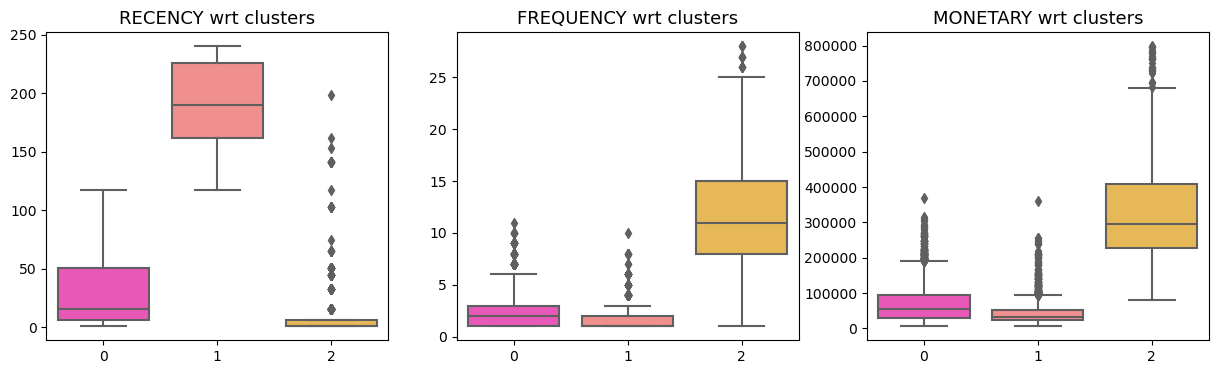

In [218]:
column = ['recency','frequency','monetary']
plt.figure(figsize=(15,4))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=df_kmeans[j], x=df_kmeans['clusters'], palette='spring')
    plt.title('{} wrt clusters'.format(j.upper()), size=13)
    plt.ylabel('')
    plt.xlabel('')

plt.show()

In [219]:
df_kmeans['clusters'].value_counts(normalize=False)

0    4240
1    2308
2     824
Name: clusters, dtype: int64

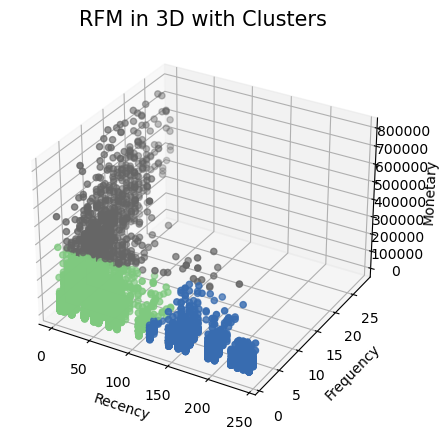

In [220]:
# Creating figure
fig = plt.figure(figsize = (8, 5))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(df_kmeans.recency, df_kmeans.frequency, df_kmeans.monetary, c=df_kmeans.clusters, cmap='Accent')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('RFM in 3D with Clusters', size=15)
ax.set(facecolor='white')
plt.show()

📍 등급별 확인

In [221]:
rfm = rfm[['membership_no', 'monetary', 'recency_score', 'frequency_score', 'monetary_score', 'customer_type']]
total_amount_of_sales = rfm['monetary'].sum() ## 구매금액 총합 = 총 매출

temp_rfm_score1 = rfm.groupby('customer_type')['membership_no'].count().reset_index().rename(columns={'membership_no':'Count'})
 
## 클래스별 구매금액(매출)계산
temp_rfm_score2 = rfm.groupby('customer_type')['monetary'].sum().reset_index()
 
## 클래스별 매출 기여도 계산
temp_rfm_score2['monetary'] = temp_rfm_score2['monetary'].map(lambda x : x/total_amount_of_sales)
 
## 데이터 결합
result_df = pd.merge(temp_rfm_score1,temp_rfm_score2,how='left',on=('customer_type'))
result_df 

,customer_type,Count,monetary
0,Bad,2596,0.105756
1,Bronze,1788,0.129363
2,Silver,1584,0.209306
3,Gold,726,0.183236
4,Platinum,719,0.372339


[참고 사이트](https://www.kaggle.com/code/mittalvasu95/cohort-rfm-k-means#III.-k-Means-Clustering)